In [19]:
from src.Utils import plot_traces, save_results, get_means
from src.Dataset import dataset_TES
from src.ExistingAlgorithms import max_value, area, sklearn_available
from src.GaussianMixture import gaussian_mixture

import matplotlib.pyplot as plt

from src.Parametric_UMAP import load_pumap
from sklearn.decomposition import PCA
import torch
import numpy as np
import polars as pl
import umap

PATH_DATA = '/home/nicolasdc/Documents/Datasets/Photon-Number-Classification/NRC CSV'
PATH_RESULTS = 'src/Results_Large'
PATH_SAVE_LD = 'src/Results_Large/Low Dimension'
PATH_SAVE_D = 'src/Results_Large/Density'

In [20]:
files_ = ['traces_attn_37dB.csv',
          #'traces_attn_35dB.csv',
          'traces_attn_33dB.csv',
          #'traces_attn_31dB.csv',
          'traces_attn_29dB.csv',
          #'traces_attn_27dB.csv',
          'traces_attn_25dB.csv',
          #'traces_attn_23dB.csv',
          'traces_attn_21dB.csv',
          #'traces_attn_19dB.csv',
          'traces_attn_17dB.csv']
data = []
for i in files_:
    data_ =  pl.read_csv(rf'{PATH_DATA}/{i}', has_header=False, separator=",").to_numpy()
    mean_it = data_[:,:10].mean()
    data.append((data_[:,::3] - mean_it))

data = np.concatenate(data, axis=0)
data_train = data[::2]
data_test = data[1::2]
mean_ = data_train.mean()
std_ = data_train.std()
data_train  = (data_train - mean_) / std_
data_test  = (data_test - mean_) / std_

In [21]:
files_ = ['traces_attn_37dB.csv',
          'traces_attn_35dB.csv',
          'traces_attn_33dB.csv',
          'traces_attn_31dB.csv',
          'traces_attn_29dB.csv',
          'traces_attn_27dB.csv',
          'traces_attn_25dB.csv',
          'traces_attn_23dB.csv',
          'traces_attn_21dB.csv',
          'traces_attn_19dB.csv',
          'traces_attn_17dB.csv']

data = []
for i in files_:
    data_ = pl.read_csv(rf'{PATH_DATA}/{i}', has_header=False, separator=",").to_numpy()
    mean_it = data_[:,:10].mean()
    data.append((data_[:,::3] - mean_it))

data = np.concatenate(data, axis=0)
data_train = data[::2]
data_test = data[1::2]

data_train  = (data_train - mean_) / std_
data_test  = (data_test - mean_) / std_

rng = np.random.default_rng(seed=42)

rng.shuffle(data_test)
rng.shuffle(data_train)

In [22]:
data_test.shape

(550000, 200)

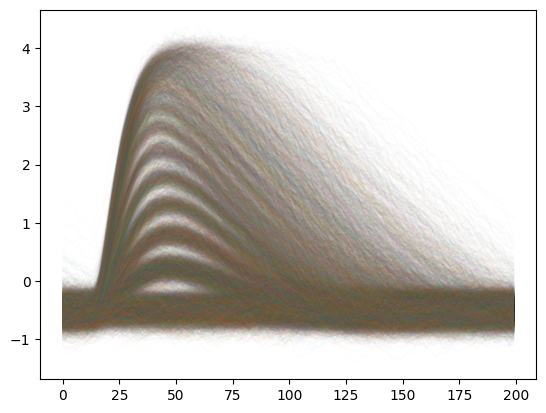

In [23]:
plt.plot(data_test[::30].T, linewidth=1, alpha=0.02)
plt.show()

### AREA

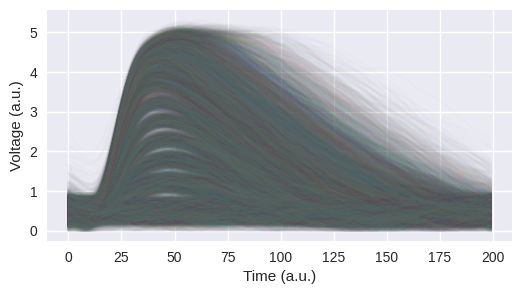

In [24]:
X_AREA  = area(data_test+1, filtering = True, plot_filter = True, threshold = 0.01, critical_frequency = 0.1)

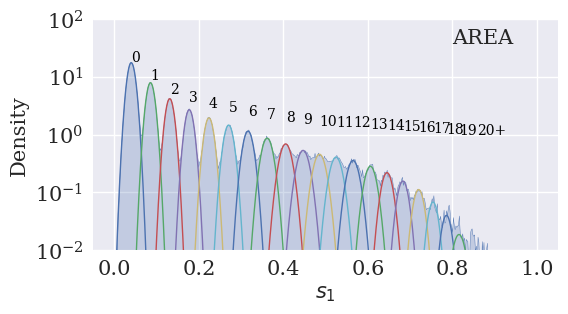

In [25]:
name_method = 'AREA'
gm = gaussian_mixture(X_AREA,
                      data_test,
                      number_cluster = 21,
                      cluster_iter = 3,
                      means_init = get_means(name_method, PATH_RESULTS),
                      tol = 1e-4,
                      info_sweep = 0,
                      plot_sweep = True)

gm.plot_density(bw_adjust = 0.03, 
                plot_gaussians = True, 
                text = name_method,
                save_path = PATH_SAVE_D)

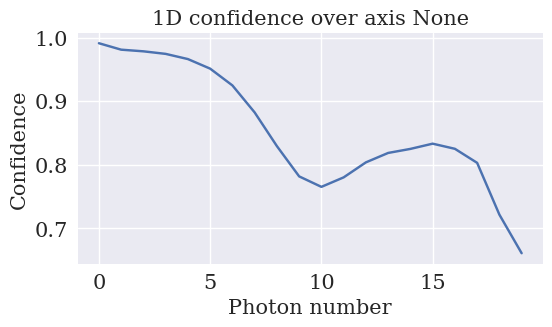

In [26]:
gm.plot_confidence_1d(expected_prob = None)
save_results(gm = gm, name_method = name_method, path = PATH_RESULTS)

### Parametric UMAP

In [27]:
data_test.shape

(550000, 200)

In [28]:
model = load_pumap('src/Parametric_UMAP/model 1D/modelLarge.ckpt').to('cpu')
X_PUMAP = model.encoder(torch.from_numpy(data_test).view(-1,200).to(dtype=torch.float)).detach().numpy()

/home/nicolasdc/anaconda3/envs/ML/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


In [29]:
import cProfile
test = torch.from_numpy(data_test).view(-1,200).to(dtype=torch.float)
cProfile.run('model.encoder(test)')

         203 function calls (167 primitive calls) in 2.755 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.411    0.411    2.755    2.755 <string>:1(<module>)
        5    0.000    0.000    0.000    0.000 __init__.py:37(__get__)
        5    0.000    0.000    0.278    0.056 activation.py:103(forward)
        5    0.000    0.000    0.457    0.091 batchnorm.py:142(forward)
        5    0.000    0.000    0.000    0.000 batchnorm.py:309(_check_input_dim)
        1    0.000    0.000    0.000    0.000 container.py:209(__iter__)
        1    0.220    0.220    2.344    2.344 container.py:217(forward)
        1    0.000    0.000    0.000    0.000 flatten.py:49(forward)
        5    0.000    0.000    0.278    0.056 functional.py:1489(relu)
        5    0.000    0.000    0.000    0.000 functional.py:2464(_verify_batch_size)
        5    0.000    0.000    0.457    0.091 functional.py:2481(batch_norm)
        6    0.000  

In [30]:
2.707 / data_test.shape[0]

4.921818181818181e-06

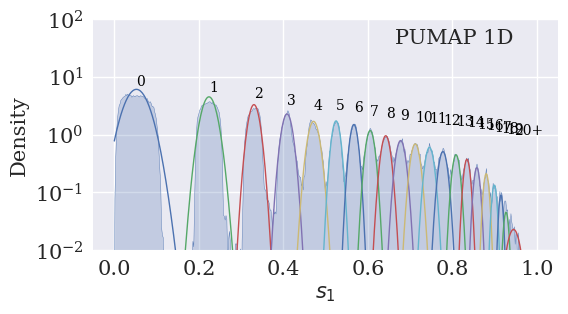

In [31]:
name_method = 'PUMAP 1D'
gm = gaussian_mixture(X_PUMAP,
                      data_test,
                      number_cluster = 21,
                      cluster_iter = 5,
                      means_init = get_means(name_method, PATH_RESULTS),
                      tol = 1e-4,
                      info_sweep = 0,
                      plot_sweep = False,
                      latex = False)

gm.plot_density(bw_adjust = 0.01,
                plot_gaussians = True, 
                text = name_method,
                save_path = PATH_SAVE_D)

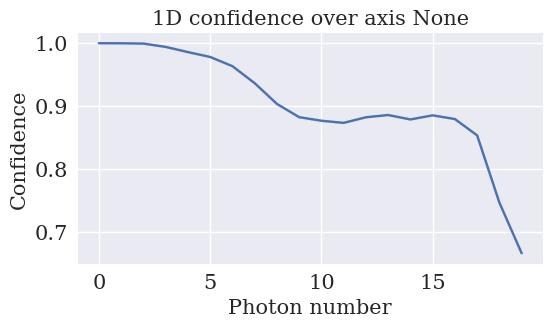

In [32]:
gm.plot_confidence_1d(expected_prob = None)
save_results(gm = gm, name_method = name_method, path = PATH_RESULTS)

### PCA

In [40]:
pca = PCA(n_components=1).fit(data_train)
X_PCA = pca.transform(data_test)

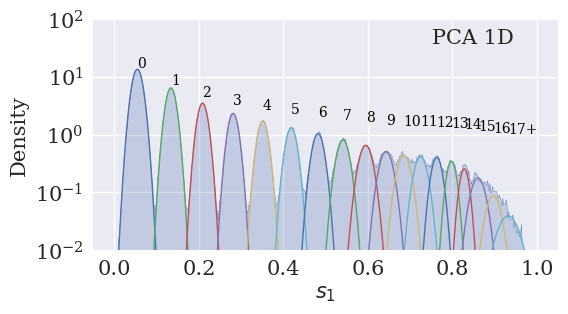

In [44]:
name_method = 'PCA 1D'
gm = gaussian_mixture(X_PCA,
                      data_test,
                      number_cluster = 18,
                      cluster_iter = 5,
                      means_init = means,#get_means(name_method, PATH_RESULTS),
                      tol = 1e-6,
                      info_sweep = 0,
                      plot_sweep = False,
                      latex = False)

gm.plot_density(bw_adjust = 0.03,
                plot_gaussians = True, 
                text = name_method,
                save_path = PATH_SAVE_D)

In [35]:
# labels = np.bincount(gm.labels)
# n_arr = np.arange(labels.shape[0])

# with plt.style.context("seaborn-v0_8"):
#     plt.figure(figsize=(6,3), dpi=100)
#     plt.rcParams['font.family'] = 'DeJavu Serif'
#     plt.rcParams['font.serif'] = ['Times New Roman']
#     plt.bar(n_arr, labels / labels.sum(), label = 'Uniform', alpha=0.5)
#     plt.ylabel('Probability')
#     plt.xlabel('Photon number')
#     plt.savefig('distribution.pdf', format='pdf', bbox_inches='tight')
#     plt.show()

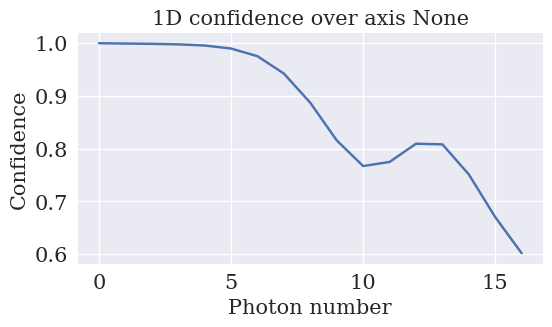

In [45]:
gm.plot_confidence_1d(expected_prob = None)
save_results(gm = gm, name_method = name_method, path = PATH_RESULTS)

### UMAP

In [37]:
X_l_UMAP = sklearn_available(data_train, data_test, PATH_SAVE_LD+'/umap1d', umap.UMAP, '100.npy', n_components=1, n_neighbors=100)

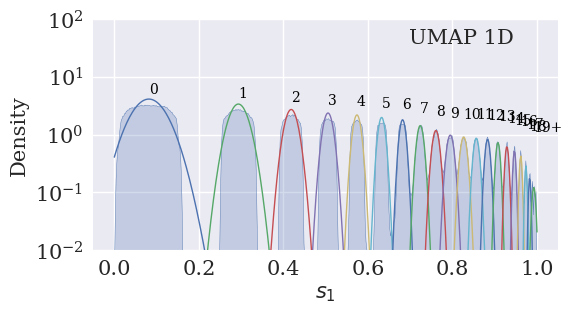

In [38]:
name_method = 'UMAP 1D'
gm = gaussian_mixture(X_low = X_l_UMAP,
                      X_high = data_test,
                      number_cluster = 20,
                      cluster_iter = 5,
                      means_init = get_means(name_method, path = PATH_RESULTS),
                      tol = 1e-4)

gm.plot_density(bw_adjust = 0.03,
                plot_gaussians = True,
                text = name_method,
                save_path = PATH_SAVE_D)


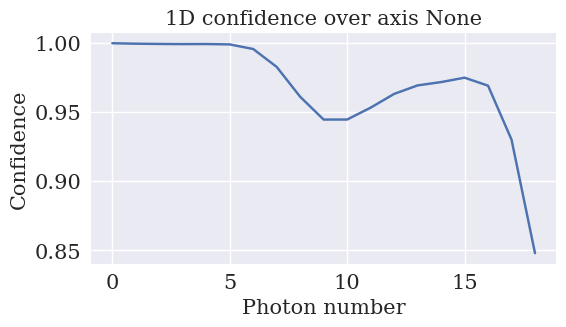

In [39]:
gm.plot_confidence_1d(expected_prob = None)
save_results(gm = gm, name_method = name_method, path = PATH_RESULTS)